In [1]:
import os
import sys

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
sys.path.append('../')

import wandb
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.utils.data import DataLoader
from data_utils import get_eval_data
from model.unet import get_unet
from utils import epoch_average
from monai.metrics import DiceMetric
from omegaconf import OmegaConf
from typing import Dict

In [2]:
def eval_set(cfg, model, dataset):
    if cfg.run.data_key == 'prostate':
        dataloader = DataLoader(dataset, batch_size=16,
                                shuffle=False, drop_last=False)

        eval_metrics = {
            "Dice Score": DiceMetric(
                ignore_empty=True,
                include_background=True
            )
        }

        metrics = eval_pmri_set(
            model=model,
            dataloader=dataloader,
            eval_metrics=eval_metrics
        )
    else:
        raise ValueError(
            f'Invalid data key. No config for dataset named {cfg.run.data_key}'
        )
    return metrics

@torch.no_grad()
def eval_pmri_set(model, dataloader, eval_metrics):
    model.eval()
    epoch_metrics = {key: [] for key in eval_metrics.keys()}
    batch_sizes = []
    i = 0
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target']
        batch_sizes.append(input_.shape[0])
        out = model(input_.cuda()).detach().cpu()
        out = torch.argmax(out, dim=1).unsqueeze(1)
        for key, metric in eval_metrics.items():
            computed_metric = metric(out, target).detach().mean().cpu()
            epoch_metrics[key].append(computed_metric)

    for key, epoch_scores in epoch_metrics.items():
        epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)
    return epoch_metrics

def get_df_from_dict(cfg, metrics: Dict):
    # convert dict into seaborn-friendly pandas format
    df = pd.DataFrame.from_dict(metrics).T
    df['Domain'] = df.index
    df.reset_index(drop=True, inplace=True)
    df = pd.melt(
        df, 
        id_vars=['Domain'],
        value_vars=df.columns.drop('Domain')
    )
    # add additional identifiers from config
    df['Iteration'] = cfg.run.iteration
    df['Model'] = cfg.unet[cfg.run.data_key].pre
    df['Data'] = cfg.run.data_key
    return df

def plot_batch(dataset, model, num_images=9, title=None):
    assert 0 < num_images <= 9
    idx = random.sample(range(len(dataset)), num_images)
    data = dataset[idx]
    with torch.no_grad():
        model.eval()
        pred = model(data['input'].cuda()).detach().cpu()
        pred = torch.argmax(pred, dim=1)

    fig, axes = plt.subplots(num_images, 4, figsize=(6, num_images*2))

    # Iterate over the images and plot them in the grid
    for i in range(num_images):
        if i == 0:
            axes[i][0].set_title('Image')
            axes[i][1].set_title('Target')
            axes[i][2].set_title('Predicted')
            axes[i][3].set_title('Diff')
        axes[i, 0].imshow(data['input'][i][0, ...], cmap='gray')
        axes[i, 1].imshow(data['target'][i][0, ...], cmap='gray')
        axes[i, 2].imshow(pred[i], cmap='gray')
        diff = torch.abs(pred[i] - data['target'][i][0, ...])
        axes[i, 3].imshow(diff, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
        axes[i, 3].axis('off')

    if title is not None:
        fig.suptitle(title, fontsize=10)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [3]:
# Set mode
MODE = 'eval'
LOG = False
ITERATION = 1
DATA_KEY = 'prostate'
# VENDOR = 'siemens'
LOAD_ONLY_PRESENT = True
extra_description = 'moredata'

cfg = OmegaConf.load('../configs/conf.yaml')
OmegaConf.update(cfg, 'run.iteration', ITERATION)
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)

unet_name = 'monai-64-4-4'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = None if unet_name == 'swinunetr' else int(args[1])
# cfg.unet[DATA_KEY].training.vendor = VENDOR
cfg.unet[DATA_KEY].training.load_only_present = LOAD_ONLY_PRESENT
cfg.wandb.project = f'{DATA_KEY}_{unet_name}_{ITERATION}{extra_description}'
if MODE == 'eval':
    # Set cfg.format to "numpy" for evaluation, otherwise don't modify it or set to "torch" for training
    cfg.format = 'numpy'
    # cfg.unet[DATA_KEY].training.subset = True # Applies for evaluation dataset only
    LOG = False

cfg.wandb.log = LOG

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])

if LOG:
    wandb.init(
        project=cfg.wandb.project,
        config={
            "learning_rate": cfg.unet[DATA_KEY].training.lr,
            "architecture": unet_name,
            "dataset": DATA_KEY
        }
    )

In [4]:
unet, state_dict = get_unet(cfg, update_cfg_with_swivels=False, return_state_dict=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device);

Loaded model from epoch 30 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_1moredata_1_best.pt


Loading evaluation PMRI dataset for vendor siemens ...
Training dataset length of vendor siemens: 1064


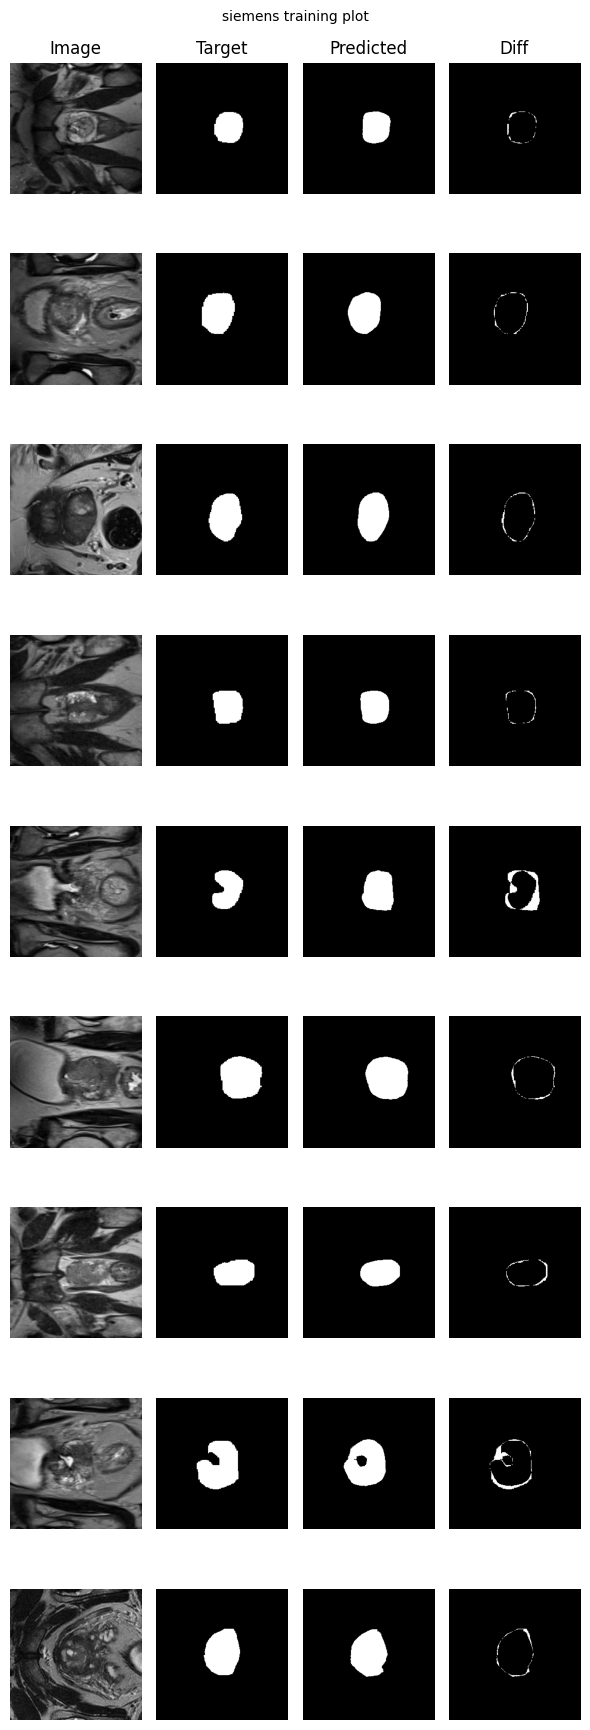

Loading evaluation PMRI dataset for vendor siemens ...
eval dataset length of vendor siemens: 196


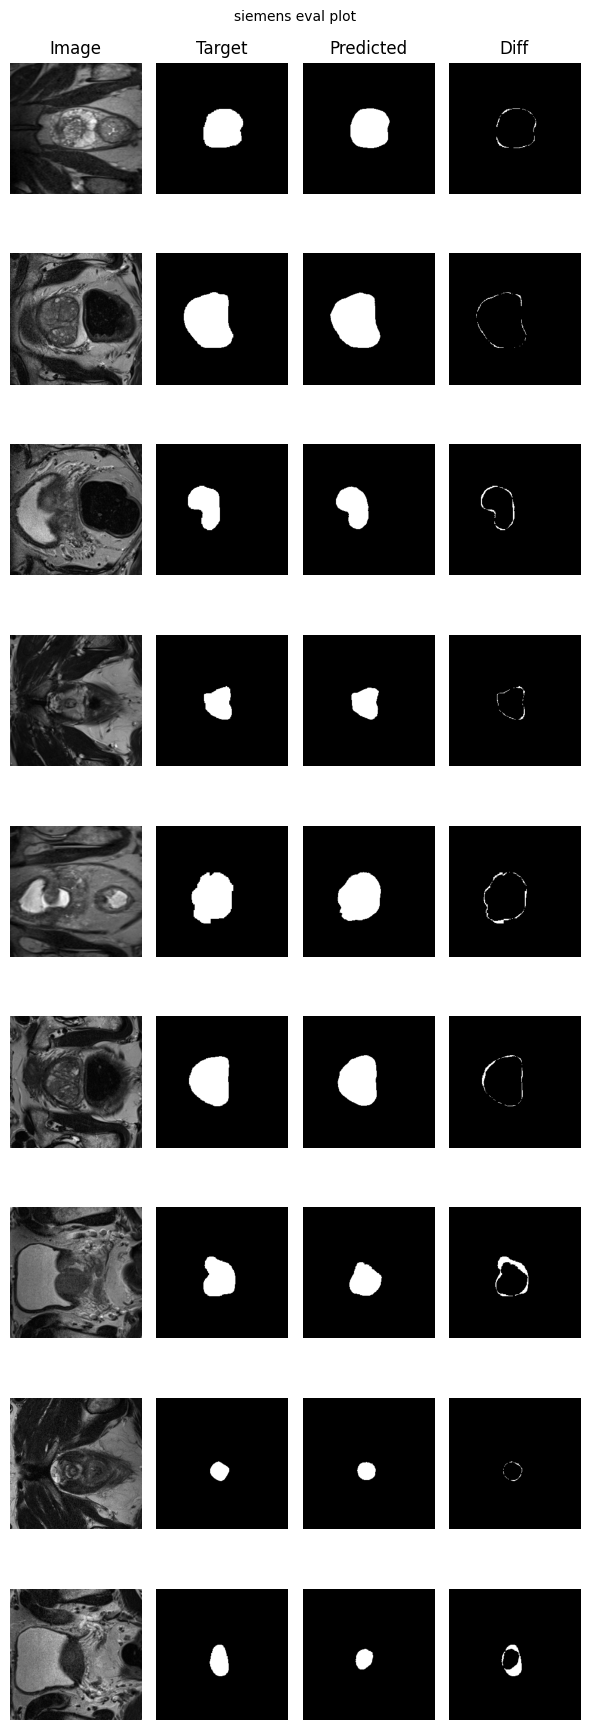

Loading evaluation PMRI dataset for vendor philips ...
eval dataset length of vendor philips: 384


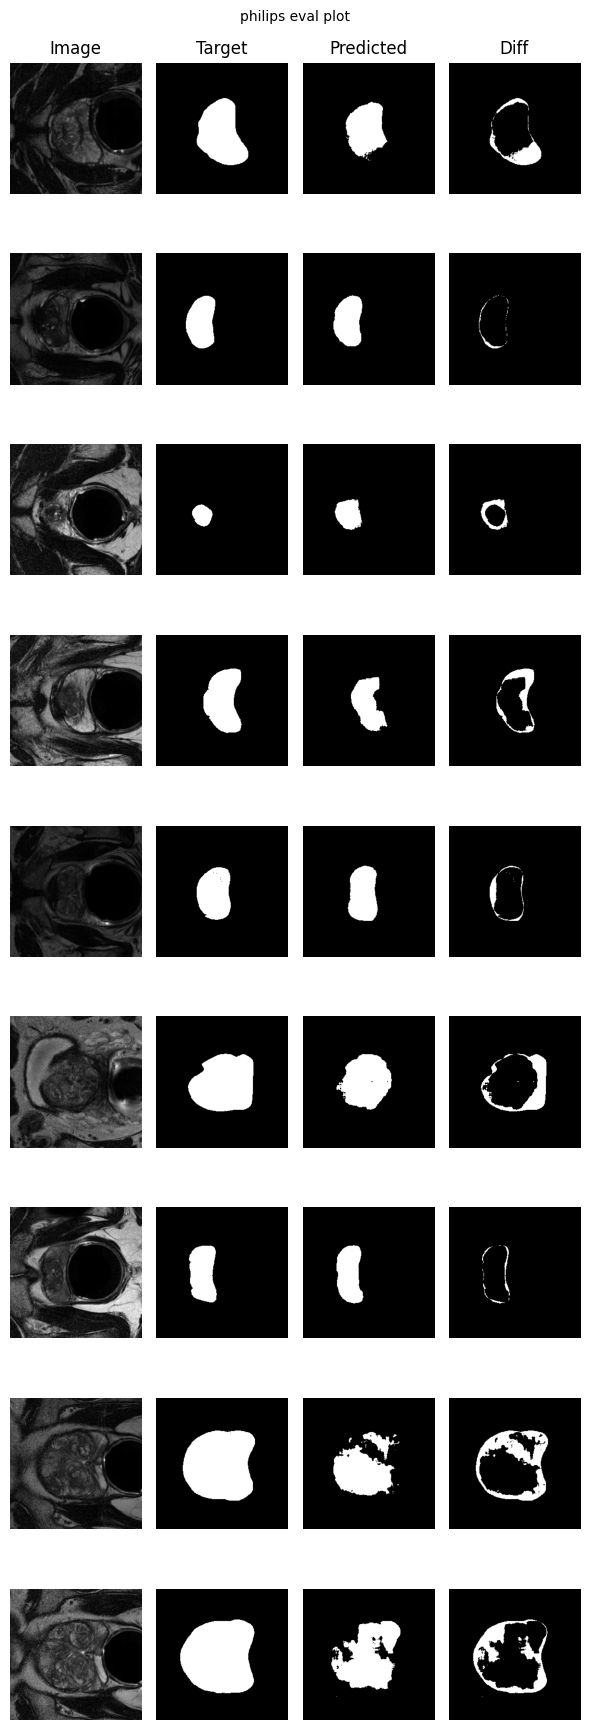

Loading evaluation PMRI dataset for vendor ge ...
eval dataset length of vendor ge: 261


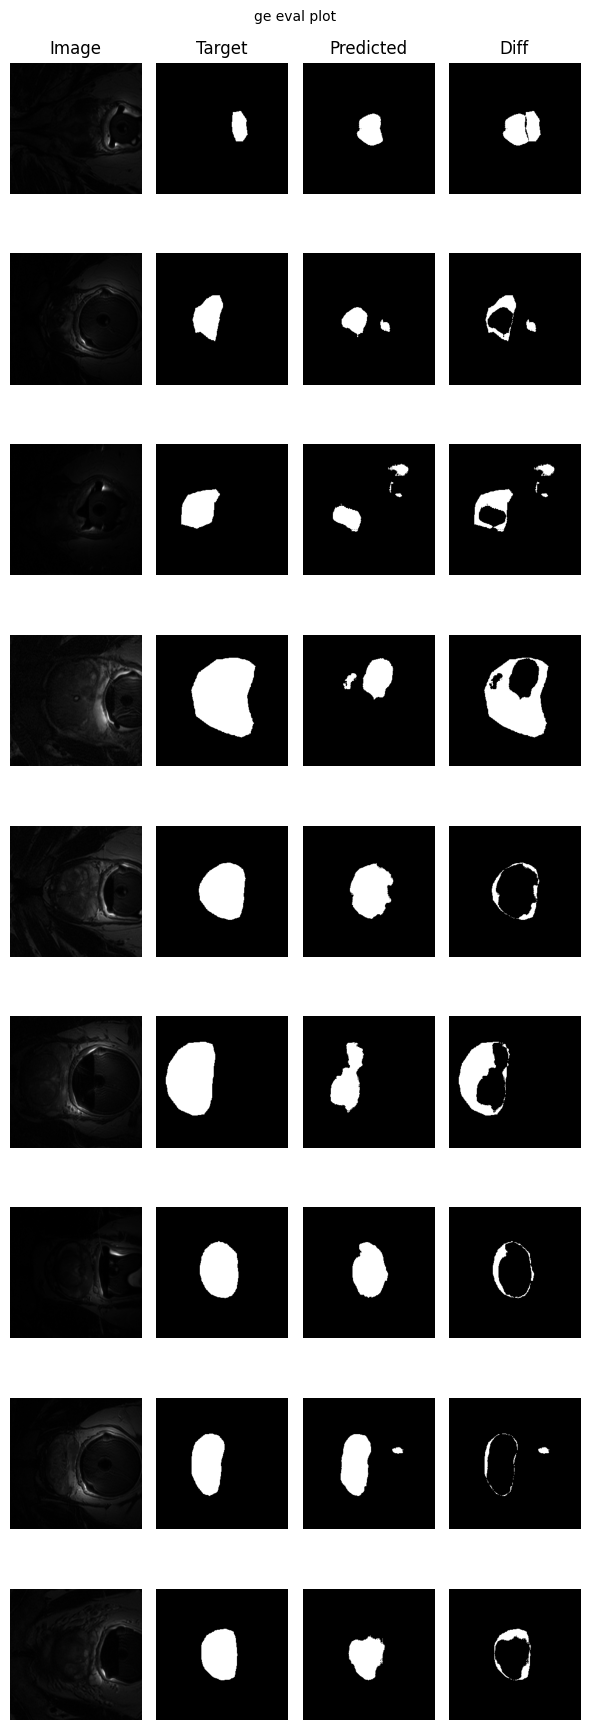

In [5]:
metrics = {}
train_vendors = ['siemens']
test_vendors = ['siemens', 'philips', 'ge']

cfg.unet[DATA_KEY].training.subset = False
for vendor in train_vendors:
    cfg.unet[DATA_KEY].training.vendor = vendor
    data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
    for key in data.keys():
        print(f'Training dataset length of vendor {vendor}: {len(data[key])}')
        metrics[f'{vendor}_train'] = eval_set(
            cfg=cfg,
            model=unet,
            dataset=data[key]
        )
        plot_batch(data[key], unet, title=f'{vendor} training plot')

for vendor in test_vendors:
    cfg.unet[DATA_KEY].training.subset = True if vendor in train_vendors else False 
    cfg.unet[DATA_KEY].training.vendor = vendor
    data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
    for key in data.keys():
        print(f'{key} dataset length of vendor {vendor}: {len(data[key])}')
        metrics[f'{vendor}_eval'] = eval_set(
            cfg=cfg,
            model=unet,
            dataset=data[key]
        )
        plot_batch(data[key], unet, title=f'{vendor} eval plot')

df = get_df_from_dict(cfg, metrics)

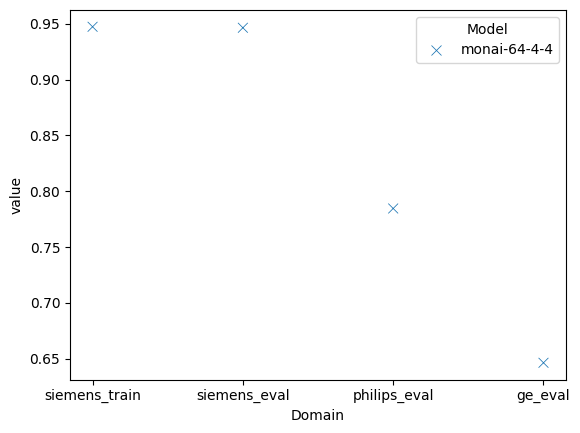

,Domain,variable,value,Iteration,Model,Data
0,siemens_train,Dice Score,0.947322,1,monai-64-4-4,prostate
1,siemens_eval,Dice Score,0.946441,1,monai-64-4-4,prostate
2,philips_eval,Dice Score,0.784578,1,monai-64-4-4,prostate
3,ge_eval,Dice Score,0.646376,1,monai-64-4-4,prostate


In [6]:
sns.scatterplot(
    data = df,
    x = 'Domain',
    y = 'value',
    hue = 'Model',
    marker = 'x',
    s = 50
)

plt.show()

df

In [7]:
# from torchviz import make_dot

In [8]:
# unet.train()
# X = torch.rand(1, 1, 256, 256).cuda()
# Y = unet(X)
# graph = make_dot(Y.mean(), params=dict(unet.named_parameters()), show_attrs=True, show_saved=True)
# graph.render("model_graph", format="png", directory="./", view=False)